This experiment shows that even after the pixels in hand-written digits images are scrambled, they can still be clustered effectively by t-SNE. It means that t-SNE doesn't take information about the translation/rotaional/illumination invariance in an image for clustering, which is very different from typical image recognition tasks. t-SNE itself doesn't have much to do with images, either.

In [1]:
import pandas as pd

# That's an impressive list of imports.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# We'll generate an animation with matplotlib and moviepy.
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [2]:
def scatter(x, colors, add_label=True):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    txts = []
    if add_label:
        # We add the labels for each digit.
        for i in range(10):
            # Position of each label.
            xtext, ytext = np.median(x[colors == i, :], axis=0)
            txt = ax.text(xtext, ytext, str(i), fontsize=24)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])
            txts.append(txt)

    return f, ax, sc, txts

### Load data

In [3]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [4]:
# http://scikit-image.org/docs/dev/auto_examples/plot_threshold_adaptive.html
from skimage.filters import threshold_otsu, threshold_adaptive

In [5]:
# Convert to binary images
for k, image in enumerate(digits.images):
    binary = image > threshold_otsu(image)
    digits.images[k] = binary

### Before scramble

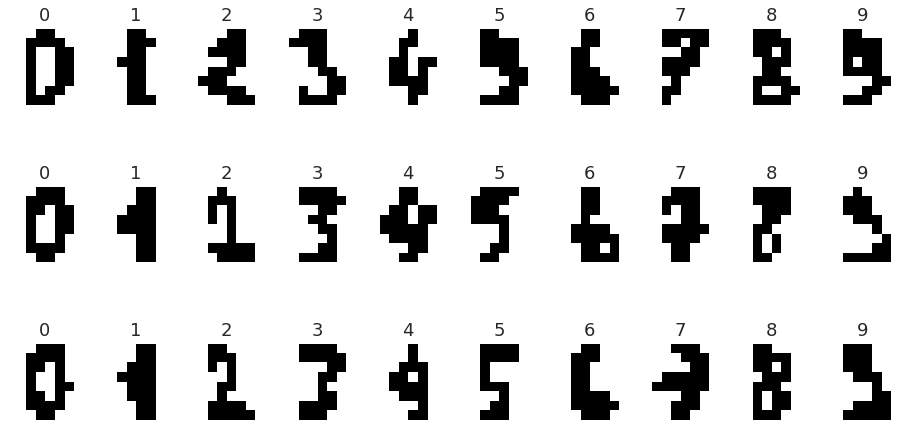

In [6]:
nrows, ncols = 3, 10
plt.figure(figsize=(16, 8))
# plt.gray()
for k, i in enumerate(range(ncols * nrows)):
    if k % 10 != digits.target[i]:
        continue
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])

In [7]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

In [8]:
digits_proj = TSNE(random_state=RS, verbose=2).fit_transform(X)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 1.087868
[t-SNE] Iteration 25: error = 1.7606806, gradient norm = 0.0056478
[t-SNE] Iteration 50: error = 1.5837369, gradient norm = 0.0041206
[t-SNE] Iteration 75: error = 1.1868770, gradient norm = 0.0016075
[t-SNE] Iteration 100: error = 1.1276174, gradient norm = 0.0013325
[t-SNE] Error after 100 iterations with early exaggeration: 1.127617
[t-SNE] Iteration 125: error = 1.0410753, gradient norm = 0.0009827
[t-SNE] Iteration 125: gradient norm 0.000983. Finished.
[t-SNE] Error after 125 iterations: 1.041075


(<matplotlib.figure.Figure at 0x7f19785de350>,
  <matplotlib.text.Text at 0x7f193501da90>])

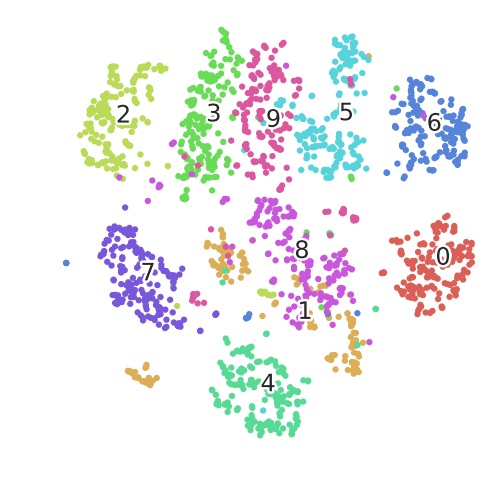

In [9]:
scatter(digits_proj, y)

### After scramble

In [10]:
digits.images.shape

(1797, 8, 8)

In [11]:
dim = digits.images.shape[1]
dim

8

In [12]:
# Generated scrambled indexes
idxes = np.random.permutation(dim ** 2).reshape((dim, dim))
idxes

array([[58, 43, 16, 19, 50, 54, 24, 10],
       [27, 15,  6, 57, 51, 21, 30, 63],
       [62, 60, 35, 42, 38, 46, 41,  1],
       [14, 33, 37, 25,  0,  8, 49, 48],
       [32, 23, 47, 40, 13,  2, 61, 53],
       [31,  3, 55, 52, 45,  9, 17,  7],
       [11, 28,  5, 36, 44, 34, 22, 12],
       [20, 18, 56, 26, 29, 59, 39,  4]])

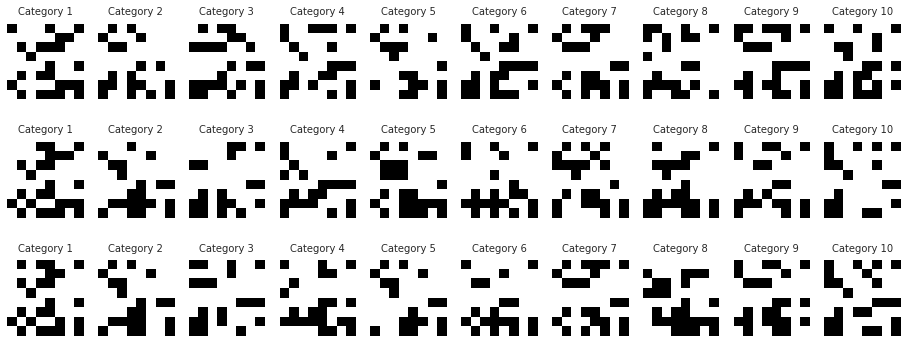

In [13]:
# Show scrambled images
nrows, ncols = 3, 10
plt.figure(figsize=(16, 6))
# plt.gray()
for k, i in enumerate(range(ncols * nrows)):
    if k % 10 != digits.target[i]:
        continue
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...].ravel()[idxes])
    plt.xticks([]); plt.yticks([])
    plt.title('Category {0}'.format(digits.target[i] + 1), fontsize=10)

In [14]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

In [15]:
df_X = pd.DataFrame(X)

In [16]:
df_X.shape

(1797, 64)

In [17]:
df_X.head(1)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0


In [18]:
df_X_scrambled = df_X[df_X.columns[idxes.ravel()]]
df_X_scrambled.head(1)

,58,43,16,19,50,54,24,10,27,15,...,22,12,20,18,56,26,29,59,39,4
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0


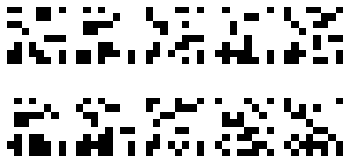

In [19]:
# Make sure columns in df_X_scrambled is indeed scrambled
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
# plt.gray()
sampled = df_X_scrambled.sample(nrows * ncols).reset_index(drop=True)
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(sampled.iloc[i].reshape(dim, dim))
    plt.xticks([]); 
    plt.yticks([])

In [20]:
digits_proj = TSNE(random_state=RS, verbose=2).fit_transform(df_X_scrambled.values)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 1.087868
[t-SNE] Iteration 25: error = 1.7559425, gradient norm = 0.0057723
[t-SNE] Iteration 50: error = 1.5810329, gradient norm = 0.0039774
[t-SNE] Iteration 75: error = 1.1893903, gradient norm = 0.0016076
[t-SNE] Iteration 100: error = 1.1299630, gradient norm = 0.0013497
[t-SNE] Error after 100 iterations with early exaggeration: 1.129963
[t-SNE] Iteration 125: error = 1.0420719, gradient norm = 0.0010134
[t-SNE] Iteration 150: error = 1.0168222, gradient norm = 0.0009223
[t-SNE] Iteration 150: gradient norm 0.000922. Finished.
[t-SNE] Error after 150 iterations: 1.016822


(<matplotlib.figure.Figure at 0x7f1934fd1ad0>,
 [])

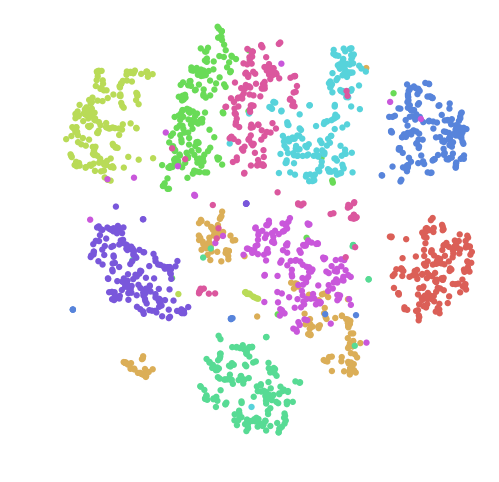

In [21]:
scatter(digits_proj, y, add_label=False)

You can see that even after being scrambled, the dataset can still be clustered in exactly the same way (with the same random seed) by t-SNE